In [2]:
!pip install dmba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 67.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from dmba import classificationSummary
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE

Colab environment detected.


In [4]:
fire = pd.read_csv('CA Fire.csv')

<ipython-input-4-85868b63b597>:1: DtypeWarning: Columns (12,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  fire = pd.read_csv('CA Fire.csv')


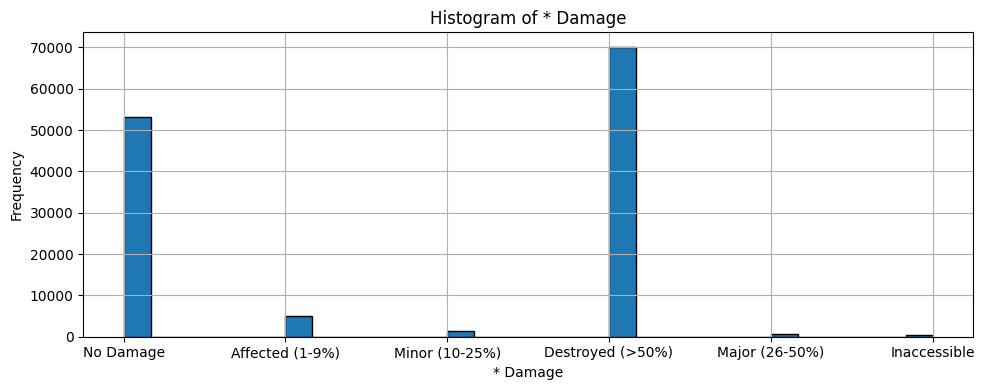

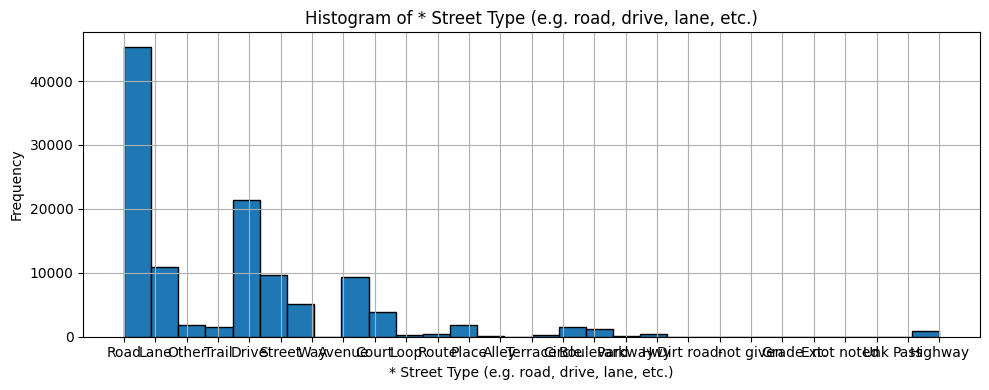

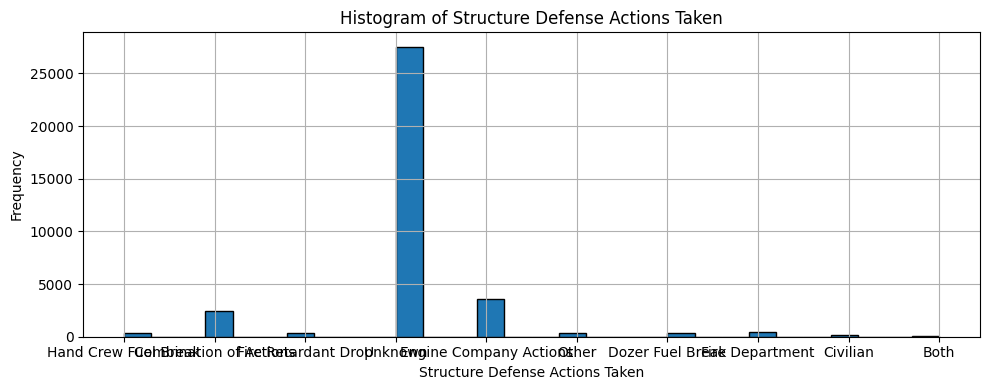

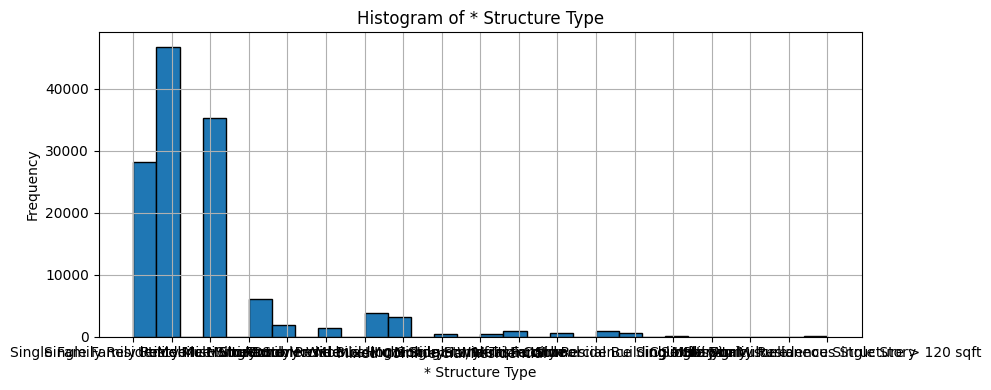

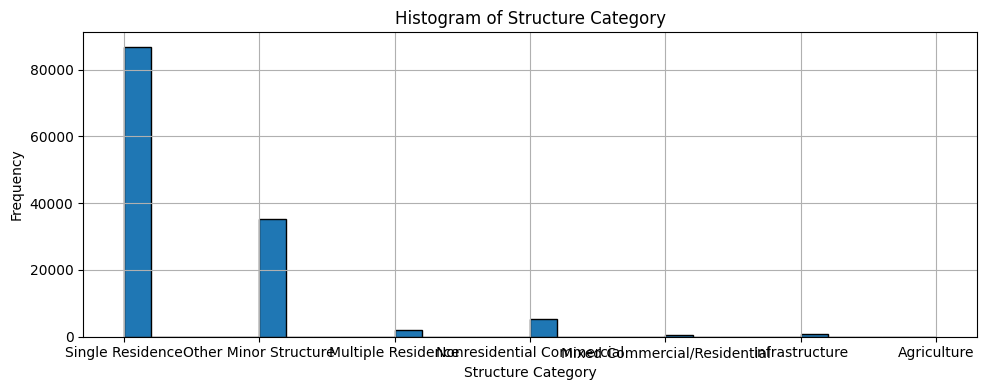

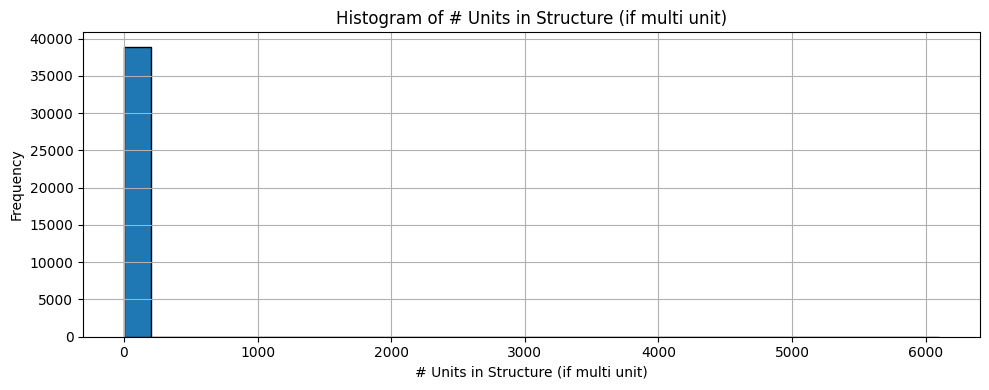

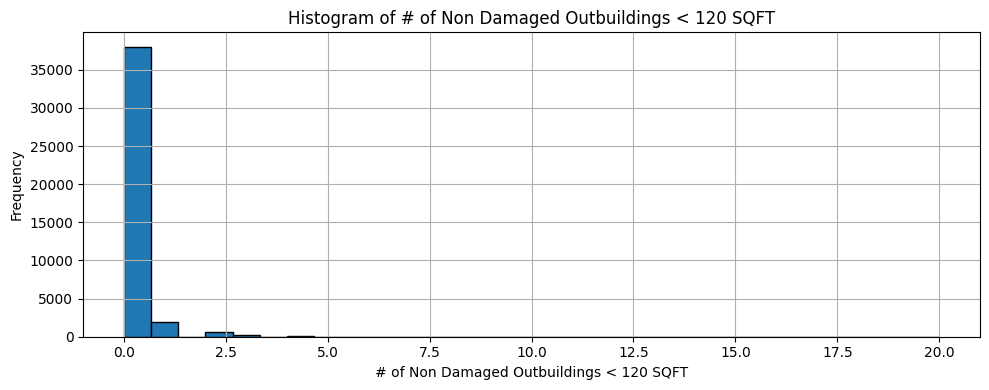

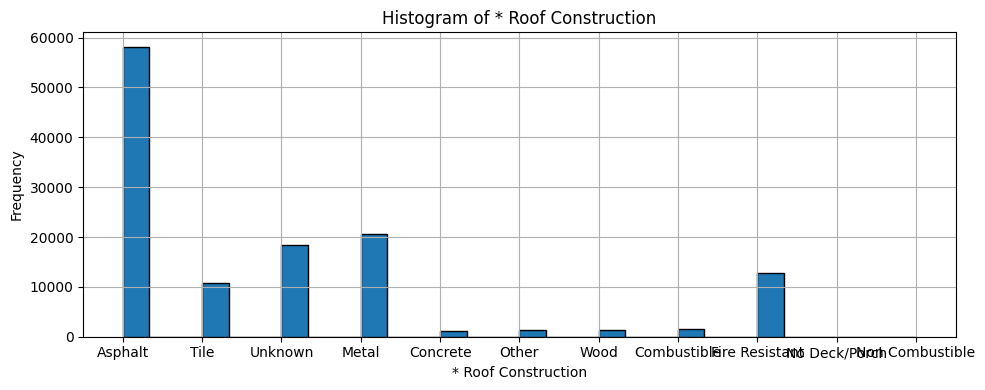

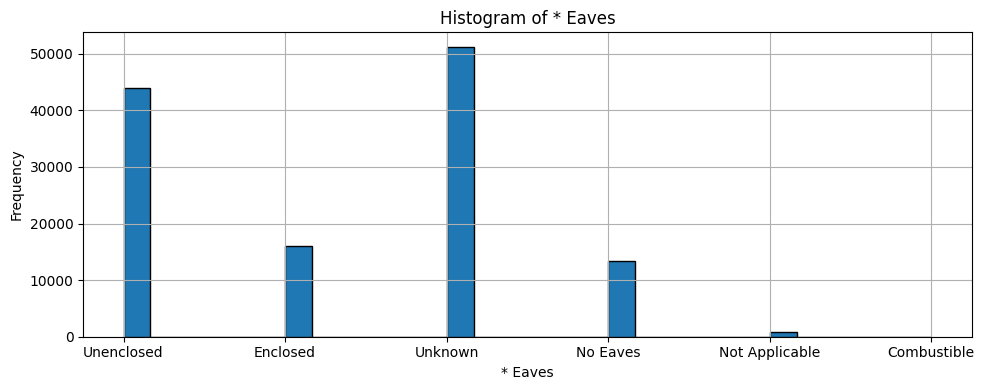

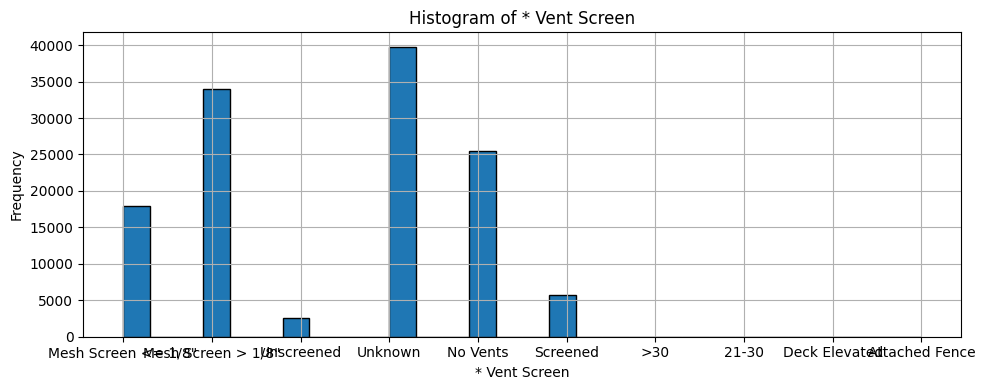

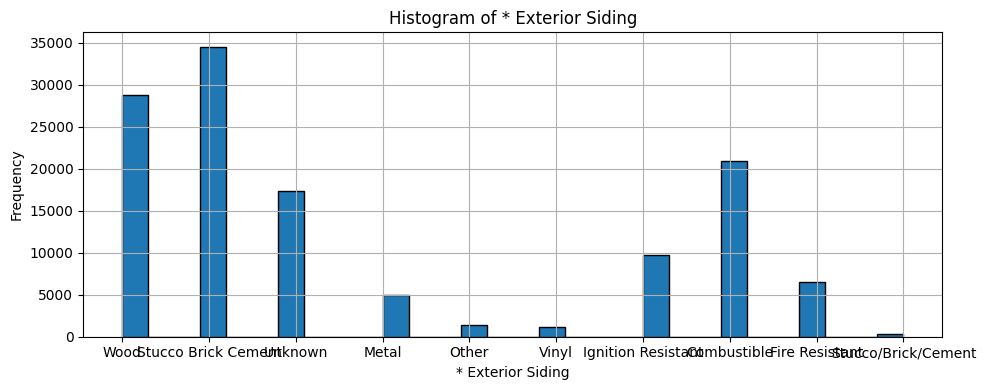

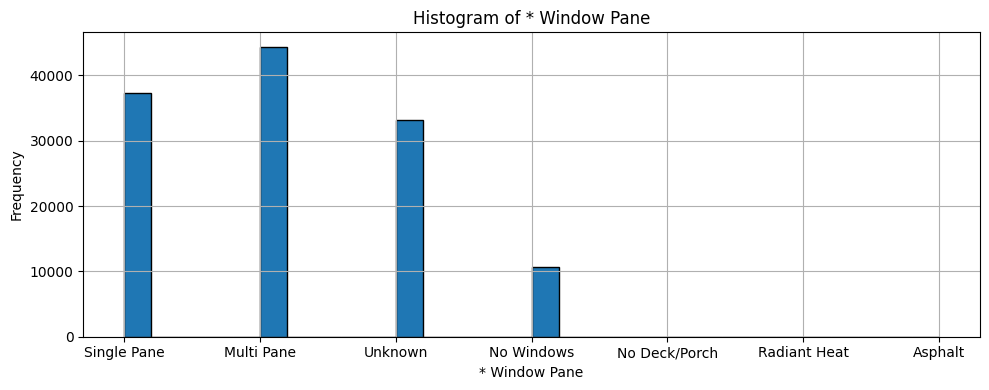

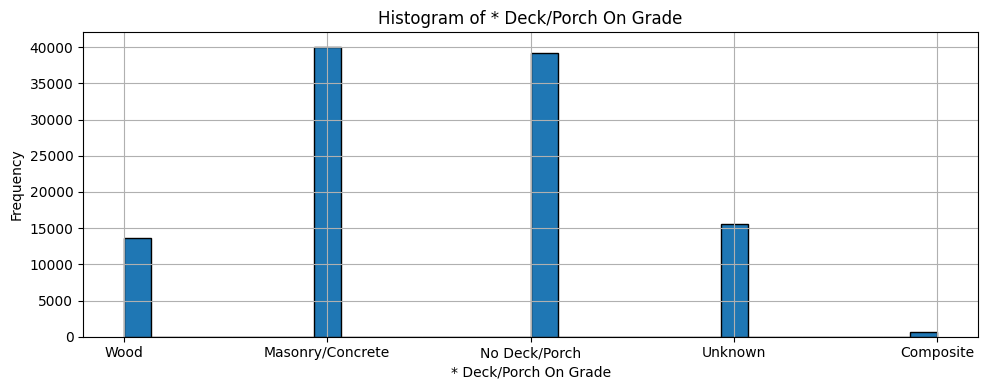

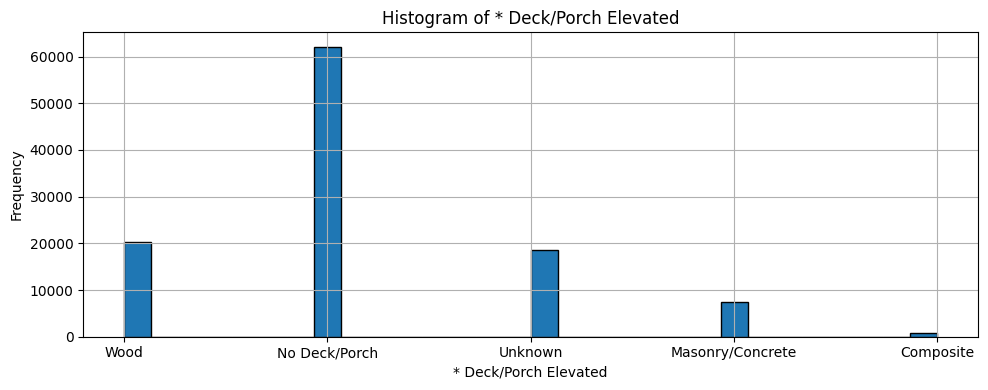

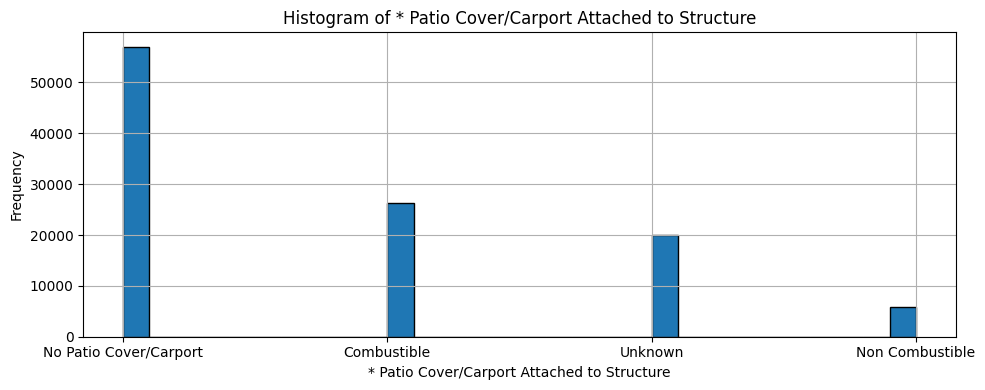

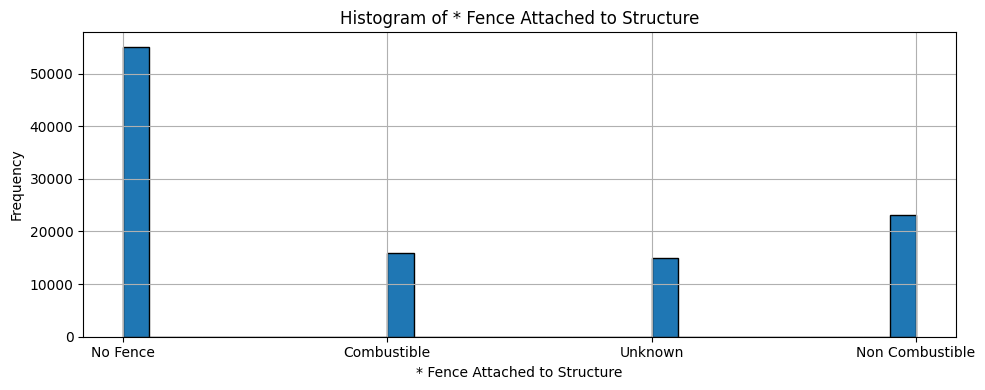

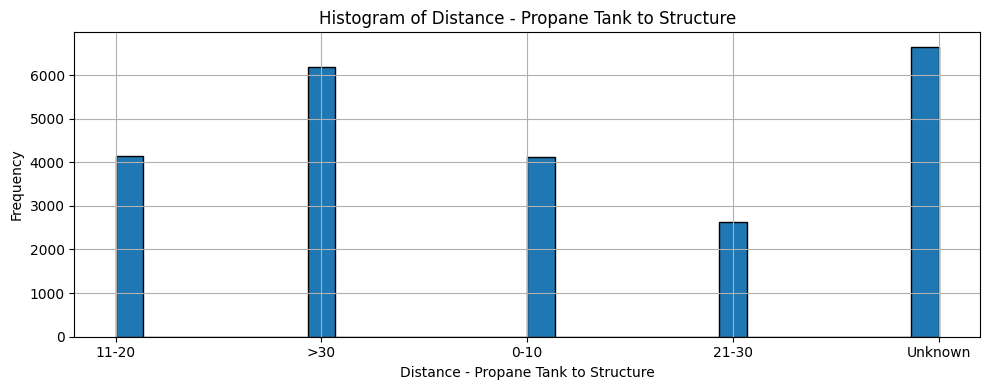

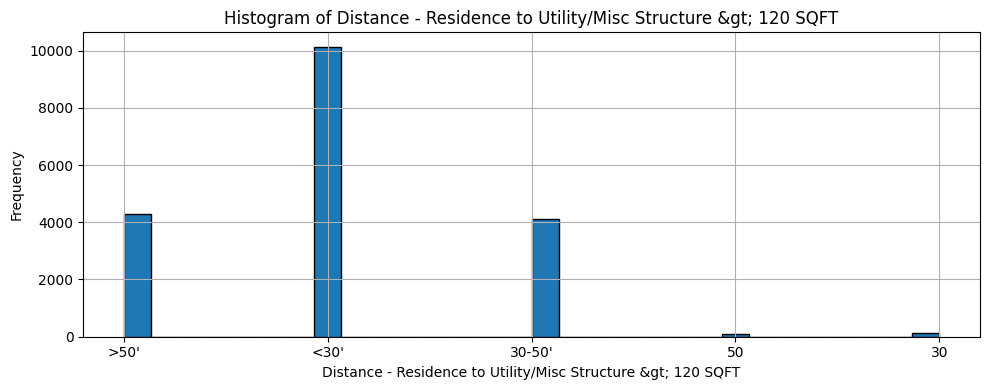

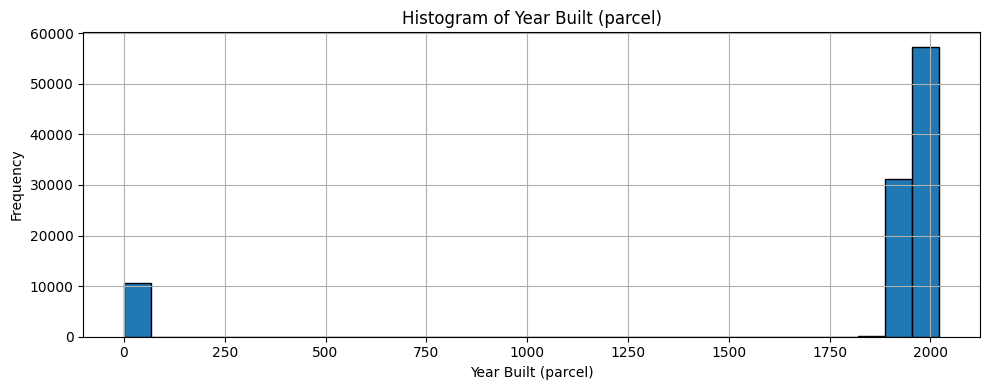

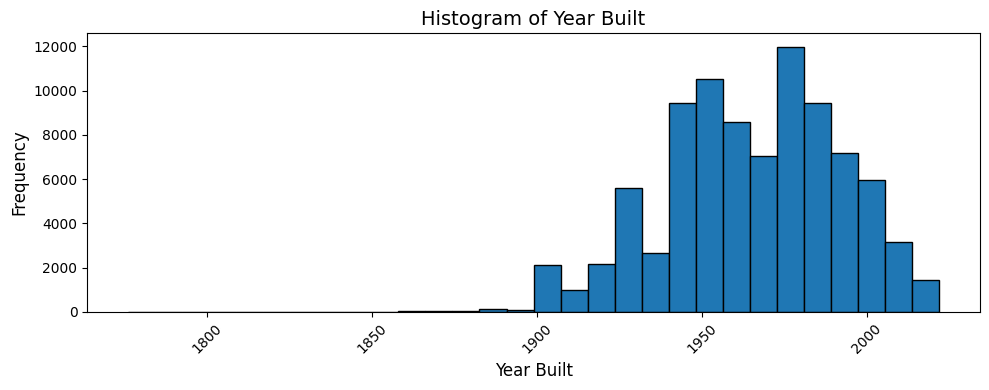

In [13]:
excluded_columns = [
    'OBJECTID', '* Street Number', '* Street Name',
    'Street Suffix (e.g. apt. 23, blding C)', '* City',
    'State', 'Zip Code', 'Community', 'Incident Number (e.g. CAAEU 123456)',
    'Incident Start Date', 'Hazard Type', 'If Affected 1-9% - Where did fire start?',
    'If Affected 1-9% - What started fire?', '# of Damaged Outbuildings < 120 SQFT',
    'Fire Name (Secondary)', 'APN (parcel)', 'Site Address (parcel)', 'GLOBALID',
    'Latitude', 'Longitude', 'x', 'y', 'Battalion', 'County', '* Incident Name',
    '* CAL FIRE Unit', 'Assessed Improved Value (parcel)'
]

columns_to_plot = [col for col in fire.columns if col not in excluded_columns]

#Plot histograms
for col in columns_to_plot:
      plt.figure(figsize=(10, 4))
      fire[col].hist(bins=30, edgecolor='black')
      plt.title(f'Histogram of {col}')
      plt.xlabel(col)
      plt.ylabel('Frequency')
      plt.tight_layout()
      plt.show()

#Year histogram
fire_filtered = fire[fire['Year Built (parcel)'] >= 1700]

plt.figure(figsize=(10, 4))
plt.hist(fire_filtered['Year Built (parcel)'], bins=30, edgecolor='black')
plt.title('Histogram of Year Built', fontsize=14)
plt.xlabel('Year Built', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
#Preprocessing
fire.drop(['OBJECTID', '* Street Number', '* Street Name',
           'Street Suffix (e.g. apt. 23, blding C)', '* City',
           'State', 'Zip Code', 'Community', 'Incident Number (e.g. CAAEU 123456)',
           'Incident Start Date', 'Hazard Type', 'If Affected 1-9% - Where did fire start?',
           'If Affected 1-9% - What started fire?','# of Damaged Outbuildings < 120 SQFT', 'Fire Name (Secondary)',
           'APN (parcel)', 'Site Address (parcel)', 'GLOBALID', 'Latitude', 'Longitude',
           'x', 'y', 'Battalion', 'County', '* Incident Name', '* CAL FIRE Unit', 'Assessed Improved Value (parcel)'],
            axis=1, inplace=True)

fire = pd.get_dummies(fire, columns=['* Street Type (e.g. road, drive, lane, etc.)', 'Structure Defense Actions Taken',
                                     '* Structure Type', 'Structure Category', '* Roof Construction', '* Eaves',
                                     '* Vent Screen', '* Exterior Siding', '* Window Pane', '* Deck/Porch On Grade',
                                     '* Deck/Porch Elevated', '* Patio Cover/Carport Attached to Structure',
                                     '* Fence Attached to Structure', 'Distance - Propane Tank to Structure',
                                     'Distance - Residence to Utility/Misc Structure &gt; 120 SQFT'], drop_first=True)

for col in fire.select_dtypes(include='bool').columns:
    if fire[col].sum() < 50:
        fire.drop(columns=col, inplace=True)

numeric_cols = fire.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if fire[col].isnull().sum() > 0:
        mean_val = fire[col].mean()
        fire[col].fillna(mean_val, inplace=True)

categorical_cols = fire.select_dtypes(include=['bool']).columns
for col in categorical_cols:
    if fire[col].isnull().sum() > 0:
        mode_value = fire[col].mode()[0]
        fire[col].fillna(mode_value, inplace=True)

print(fire.dtypes)

* Damage                                                                object
# Units in Structure (if multi unit)                                   float64
# of Non Damaged Outbuildings < 120 SQFT                               float64
Year Built (parcel)                                                    float64
* Street Type (e.g. road, drive, lane, etc.)_Avenue                       bool
                                                                        ...   
Distance - Propane Tank to Structure_Unknown                              bool
Distance - Residence to Utility/Misc Structure &gt; 120 SQFT_30-50'       bool
Distance - Residence to Utility/Misc Structure &gt; 120 SQFT_50           bool
Distance - Residence to Utility/Misc Structure &gt; 120 SQFT_<30'         bool
Distance - Residence to Utility/Misc Structure &gt; 120 SQFT_>50'         bool
Length: 107, dtype: object


<ipython-input-4-4f7b33bc242c>:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fire[col].fillna(mean_val, inplace=True)


Confusion Matrix (Accuracy 0.5198)

                 Prediction
          Actual  Affected (1-9%) Destroyed (>50%)     Inaccessible   Major (26-50%)   Minor (10-25%)        No Damage
 Affected (1-9%)            11950             3972               52             1628             3400             7132
Destroyed (>50%)             1028            24352               80              261              268             2145
    Inaccessible              733             2270            19558               13              485             5075
  Major (26-50%)             9700             4151              141             3657             5038             5447
  Minor (10-25%)            10829             4018               18             2734             5943             4592
       No Damage             2125             2534              394              255              537            22289
                  precision    recall  f1-score   support

 Affected (1-9%)       0.33      0.42      0

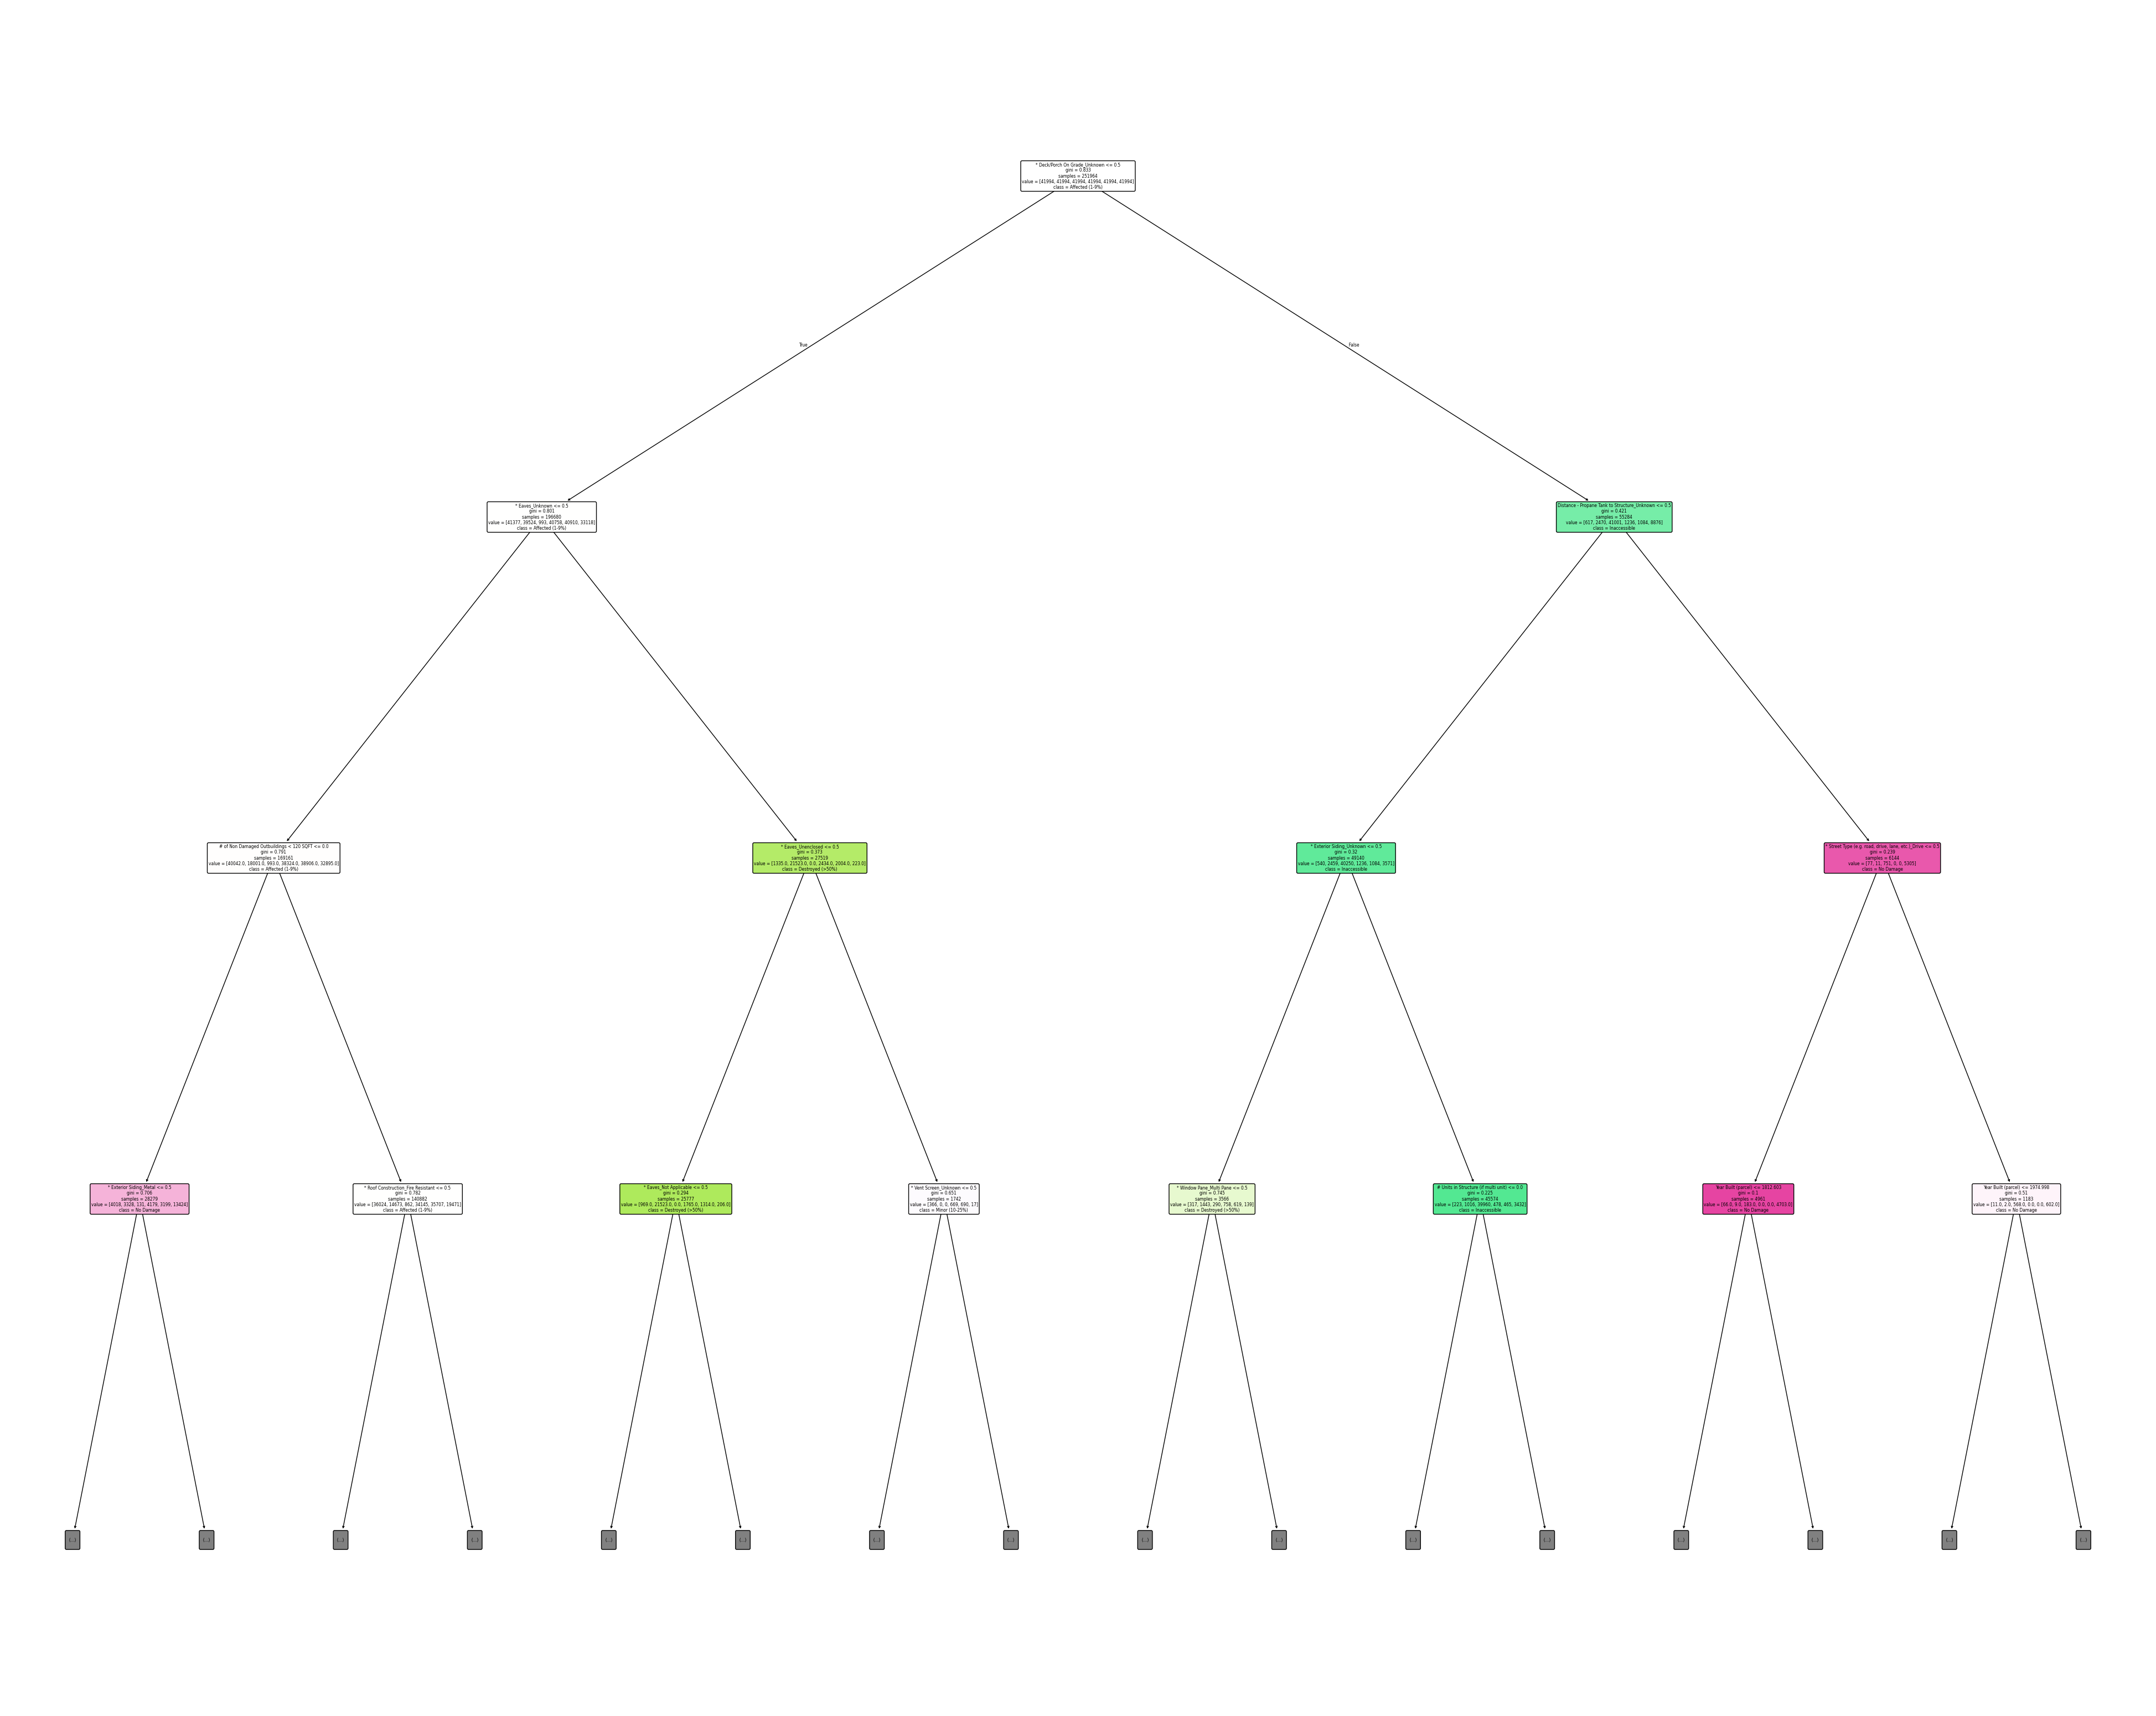

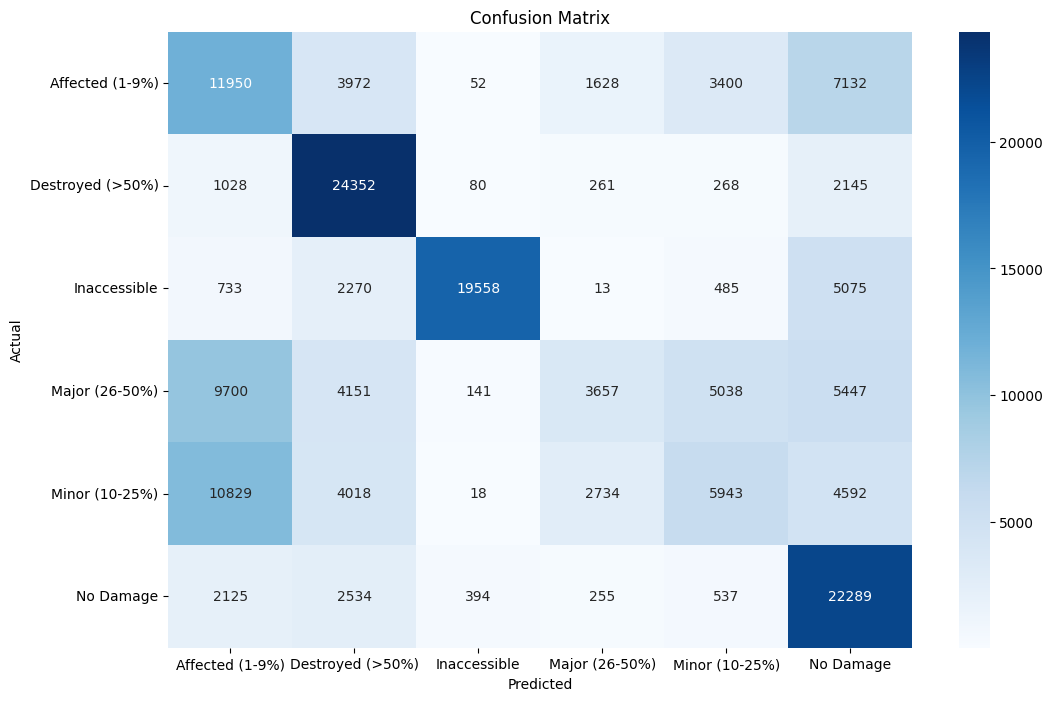

In [5]:
#Single Tree for Interpretability
X = fire.drop(columns='* Damage')
y = fire['* Damage']

#Oversample to fix imbalanced data
smote = SMOTE()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train = X_train_resampled
y_train = y_train_resampled
X_valid_resampled, y_valid_resampled = smote.fit_resample(X_valid, y_valid)
X_valid = X_valid_resampled
y_valid = y_valid_resampled

single = DecisionTreeClassifier(random_state = 1)
single.fit(X_train, y_train)
classes = single.classes_

classificationSummary(y_valid, single.predict(X_valid), class_names=classes)
print(classification_report(y_valid, single.predict(X_valid)))
feature_importances = pd.Series(single.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)
print(top_features)

plt.figure(figsize=(50, 40))
plot_tree(single,
          feature_names=X.columns,
          class_names=[str(cls) for cls in single.classes_],
          filled=True,
          rounded=True, max_depth = 3)
plt.show()

cm = confusion_matrix(y_valid, single.predict(X_valid), labels=single.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=single.classes_, yticklabels=single.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

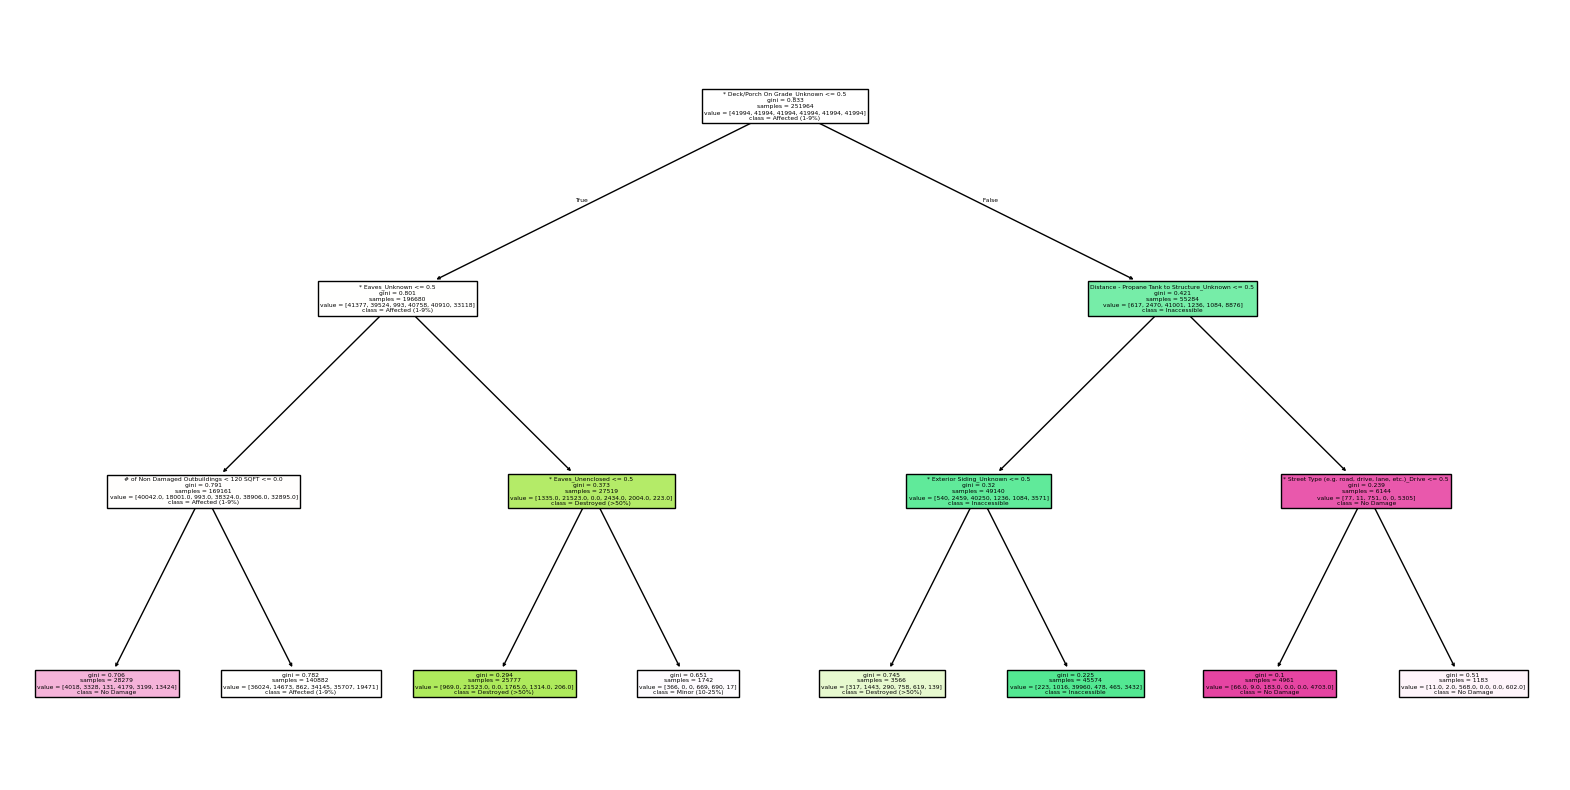

In [9]:
from sklearn import tree

single = DecisionTreeClassifier(max_depth=3, random_state = 1)
single.fit(X_train, y_train)
classes = single.classes_

fig = plt.figure(figsize = (20, 10))
tree.plot_tree(single,
          feature_names=X.columns,
          class_names=[str(cls) for cls in single.classes_],
          filled=True)
plt.show()

Confusion Matrix (Accuracy 0.5740)

                 Prediction
          Actual  Affected (1-9%) Destroyed (>50%)     Inaccessible   Major (26-50%)   Minor (10-25%)        No Damage
 Affected (1-9%)            16432             2802               11              532              972             7306
Destroyed (>50%)              368            25083               69               77              164             2294
    Inaccessible              574             1390            23907              162               32             1990
  Major (26-50%)            14646             3761              101             2694             3445             3408
  Minor (10-25%)            15699             3617              107             1198             3097             4337
       No Damage             1019             1265              256               34               72            25409
                  precision    recall  f1-score   support

 Affected (1-9%)       0.34      0.59      0

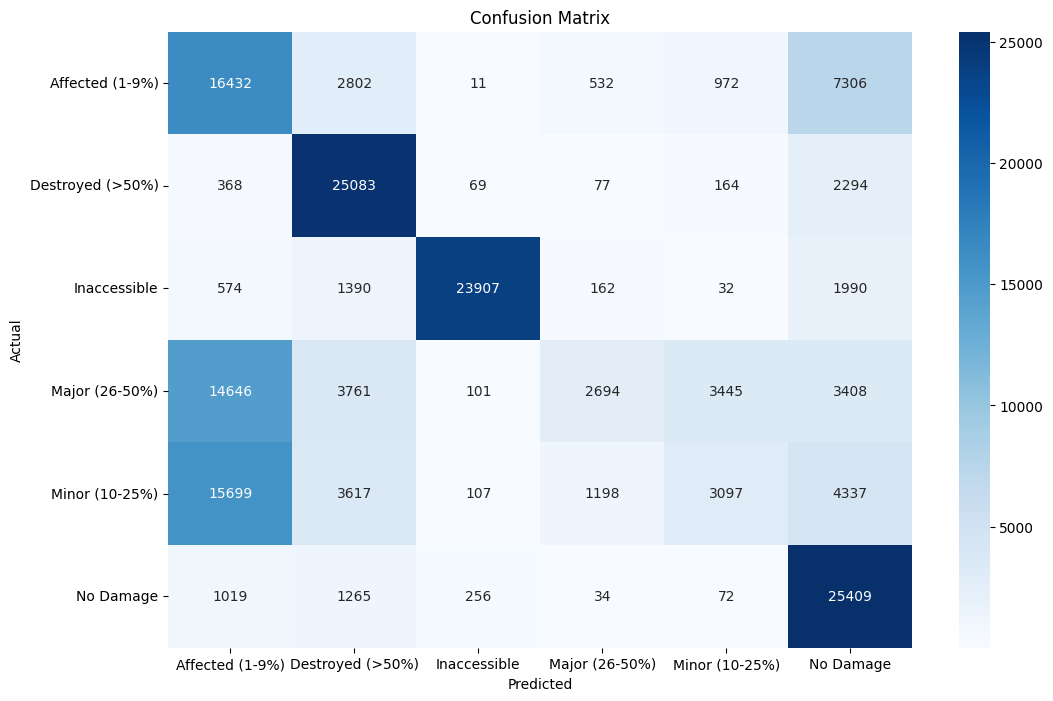

In [13]:
#Random Forest
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train, y_train)
classes = rf.classes_

classificationSummary(y_valid, rf.predict(X_valid), class_names=classes)
print(classification_report(y_valid, rf.predict(X_valid)))

importances = np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)
feature_importances = pd.Series(importances, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)
print(top_features)

cm = confusion_matrix(y_valid, rf.predict(X_valid), labels=rf.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=rf.classes_, yticklabels=rf.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix (Accuracy 0.5477)

                 Prediction
          Actual  Affected (1-9%) Destroyed (>50%)     Inaccessible   Major (26-50%)   Minor (10-25%)        No Damage
 Affected (1-9%)            14176             2970               11             1538             2600             6760
Destroyed (>50%)              558            24846               69              143              213             2226
    Inaccessible              484             1666            20393              578              152             4782
  Major (26-50%)            11372             3710               19             3955             5031             3968
  Minor (10-25%)            12951             3923               56             2378             4469             4278
       No Damage             1573             1492              186              146              308            24350
                  precision    recall  f1-score   support

 Affected (1-9%)       0.34      0.51      0

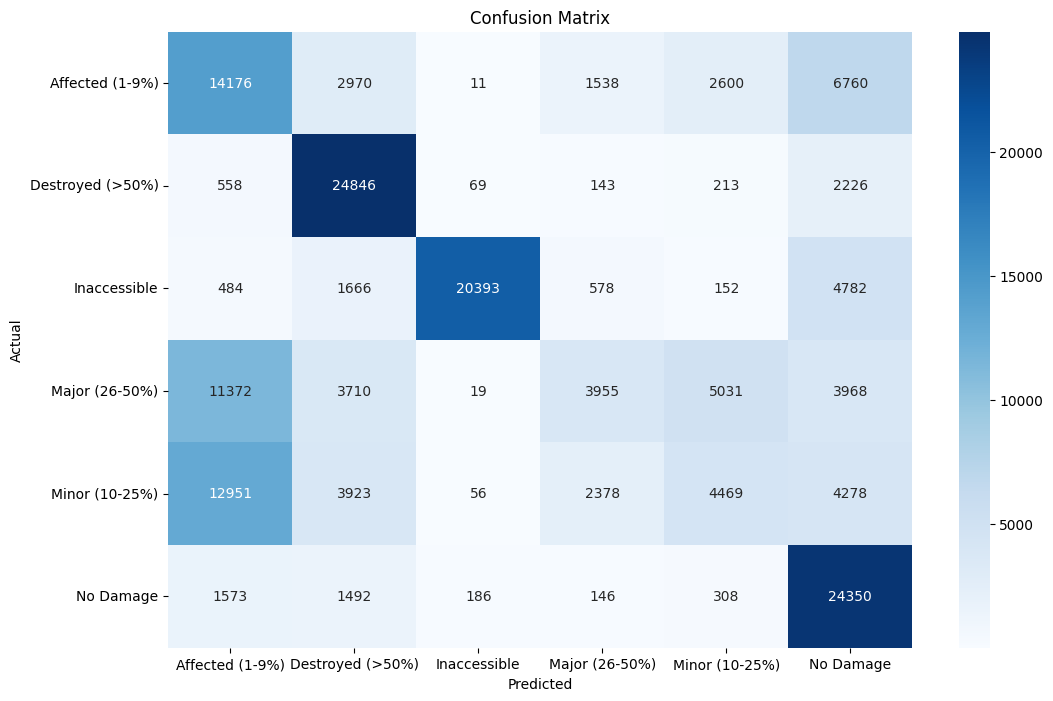

In [14]:
#Bootstrap Aggregation with 100 base learners
bagging = BaggingClassifier(DecisionTreeClassifier(),
                            n_estimators=100, random_state=1)
bagging.fit(X_train, y_train)
classes = bagging.classes_
classificationSummary(y_valid, bagging.predict(X_valid), class_names=classes)
print(classification_report(y_valid, bagging.predict(X_valid)))

importances = np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0)
feature_importances = pd.Series(importances, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)
print(top_features)

cm = confusion_matrix(y_valid, bagging.predict(X_valid), labels=bagging.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=bagging.classes_, yticklabels=bagging.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

Confusion Matrix (Accuracy 0.5438)

                 Prediction
          Actual  Affected (1-9%) Destroyed (>50%)     Inaccessible   Major (26-50%)   Minor (10-25%)        No Damage
 Affected (1-9%)            12674             3687               29              742             1280             9643
Destroyed (>50%)              481            25004               73               93              186             2218
    Inaccessible              399             1951            22651              182               57             2815
  Major (26-50%)            10156             5149               22             2986             4219             5523
  Minor (10-25%)            11986             4917               98             1454             2957             6643
       No Damage              883             1564              172               70              107            25259
                  precision    recall  f1-score   support

 Affected (1-9%)       0.35      0.45      0

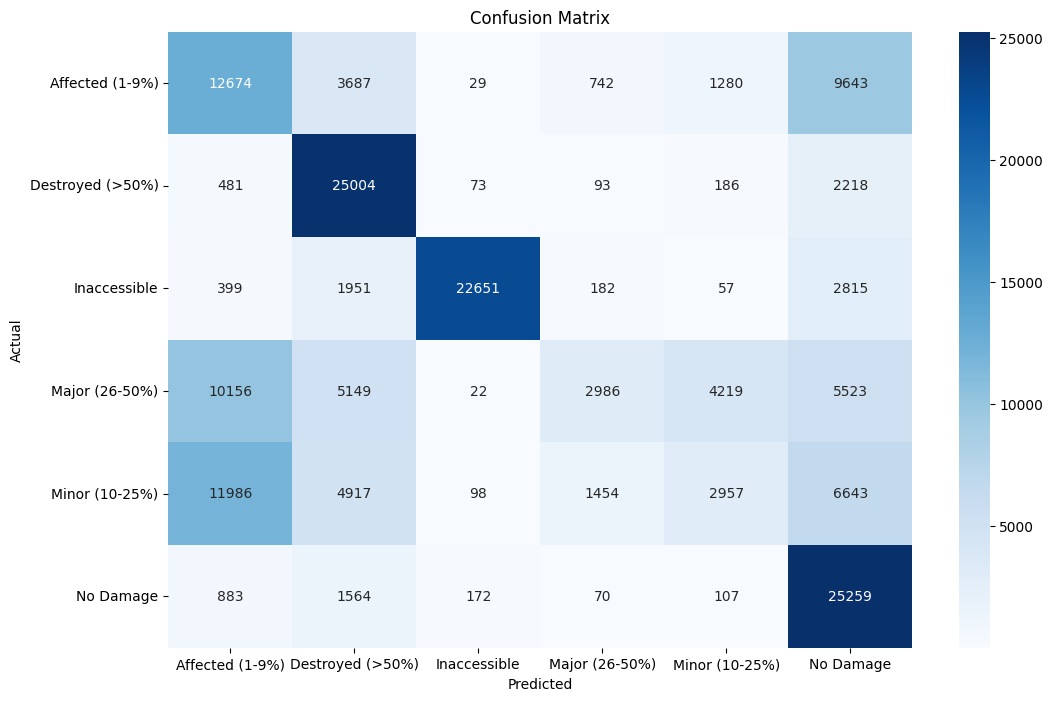

In [15]:
#Gradient Boosting with 100 base models
boost = AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=100, random_state=1)
boost.fit(X_train, y_train)

classes = boost.classes_
classificationSummary(y_valid, boost.predict(X_valid), class_names=classes)
print(classification_report(y_valid, boost.predict(X_valid)))

importances = np.mean([tree.feature_importances_ for tree in boost.estimators_], axis=0)
feature_importances = pd.Series(importances, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)
print(top_features)

cm = confusion_matrix(y_valid, boost.predict(X_valid), labels=boost.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=boost.classes_, yticklabels=boost.classes_, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()